In [1]:
%matplotlib inline

## https://pyro.ai/numpyro/examples/sparse_regression.html#sphx-glr-download-examples-sparse-regression-py

## Note: I changed sample_theta_space() method to sample_theta_space_trial() to only sample active dimensions and dimensions with pairwise interactions and show psoterior distributions in corner plots, and I also added corresponding changes to main() method


Sparse Regression
=================

We demonstrate how to do (fully Bayesian) sparse linear regression using the
approach described in [1]. This approach is particularly suitable for situations
with many feature dimensions (large P) but not too many datapoints (small N).
In particular we consider a quadratic regressor of the form:

\begin{align}f(X) = \text{constant} + \sum_i \theta_i X_i + \sum_{i<j} \theta_{ij} X_i X_j + \text{observation noise}\end{align}

**References:**

    1. Raj Agrawal, Jonathan H. Huggins, Brian Trippe, Tamara Broderick (2019),
       "The Kernel Interaction Trick: Fast Bayesian Discovery of Pairwise Interactions in High Dimensions",
       (https://arxiv.org/abs/1905.06501)


In [1]:
import argparse
import itertools
import os
import time

import numpy as onp

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import corner

def dot(X, Z):
    return np.dot(X, Z[..., None])[..., 0]


# The kernel that corresponds to our quadratic regressor. (According to prop 6.1)
def kernel(X, Z, eta1, eta2, c, jitter=1.0e-6):
    eta1sq = np.square(eta1)
    eta2sq = np.square(eta2)
    k1 = 0.5 * eta2sq * np.square(1.0 + dot(X, Z))
    k2 = -0.5 * eta2sq * dot(np.square(X), np.square(Z))
    k3 = (eta1sq - eta2sq) * dot(X, Z)
    k4 = np.square(c) - 0.5 * eta2sq
    if X.shape == Z.shape:
        k4 += jitter * np.eye(X.shape[0])
    return k1 + k2 + k3 + k4


# Most of the model code is concerned with constructing the sparsity inducing prior.
def model(X, Y, hypers):
    # Here X is the design matrix with N x p dimensions
    # read off dimensions P and N
    # S ??? - like a sparsity coeff? 
    S, P, N = hypers['expected_sparsity'], X.shape[1], X.shape[0]

    # sample variables from p. 18
    sigma = numpyro.sample("sigma", dist.HalfNormal(hypers['alpha3']))
    phi = sigma * (S / np.sqrt(N)) / (P - S)
    eta1 = numpyro.sample("eta1", dist.HalfCauchy(phi))

    msq = numpyro.sample("msq", dist.InverseGamma(hypers['alpha1'], hypers['beta1']))
    xisq = numpyro.sample("xisq", dist.InverseGamma(hypers['alpha2'], hypers['beta2']))

    eta2 = np.square(eta1) * np.sqrt(xisq) / msq

    lam = numpyro.sample("lambda", dist.HalfCauchy(np.ones(P)))
    kappa = np.sqrt(msq) * lam / np.sqrt(msq + np.square(eta1 * lam))

    # sample observation noise
    var_obs = numpyro.sample("var_obs", dist.InverseGamma(hypers['alpha_obs'], hypers['beta_obs']))

    # compute kernel (as in proposition 6.1)
    kX = kappa * X
    k = kernel(kX, kX, eta1, eta2, hypers['c']) + var_obs * np.eye(N)
    assert k.shape == (N, N)

    # sample Y according to the standard gaussian process formula
    numpyro.sample("Y", dist.MultivariateNormal(loc=np.zeros(X.shape[0]), covariance_matrix=k),
                   obs=Y)

    
    
# I guess broadly corresponds to Section 5 of the paper??

# Compute the mean and variance of coefficient theta_i (where i = dimension) for a
# MCMC sample of the kernel hyperparameters (eta1, xisq, ...).
# Compare to theorem 5.1 in reference [1].
def compute_singleton_mean_variance(X, Y, dimension, msq, lam, eta1, xisq, c, var_obs):
    P, N = X.shape[1], X.shape[0]

    probe = np.zeros((2, P))
    probe = jax.ops.index_update(probe, jax.ops.index[:, dimension], np.array([1.0, -1.0]))

    eta2 = np.square(eta1) * np.sqrt(xisq) / msq
    kappa = np.sqrt(msq) * lam / np.sqrt(msq + np.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + var_obs * np.eye(N)
    k_xx_inv = np.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    vec = np.array([0.50, -0.50]) ## a = (1/2, -1/2)
    mu = np.matmul(k_probeX, np.matmul(k_xx_inv, Y))
    mu = np.dot(mu, vec)

    var = k_prbprb - np.matmul(k_probeX, np.matmul(k_xx_inv, np.transpose(k_probeX)))
    var = np.matmul(var, vec)
    var = np.dot(var, vec)

    return mu, var


# Compute the mean and variance of coefficient theta_ij for a MCMC sample of the
# kernel hyperparameters (eta1, xisq, ...). Compare to theorem 5.1 in reference [1].
def compute_pairwise_mean_variance(X, Y, dim1, dim2, msq, lam, eta1, xisq, c, var_obs):
    # Here X is the design matrix with N x p dimensions
    # read off dimensions P and N
    P, N = X.shape[1], X.shape[0]

    probe = np.zeros((4, P))
    probe = jax.ops.index_update(probe, jax.ops.index[:, dim1], np.array([1.0, 1.0, -1.0, -1.0]))
    probe = jax.ops.index_update(probe, jax.ops.index[:, dim2], np.array([1.0, -1.0, 1.0, -1.0]))
    
    
    # compute eta2 and kappa from p. 18 

    eta2 = np.square(eta1) * np.sqrt(xisq) / msq
    kappa = np.sqrt(msq) * lam / np.sqrt(msq + np.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    # ?? compute a bunch of matrices w/ kernels ??
    k_xx = kernel(kX, kX, eta1, eta2, c) + var_obs * np.eye(N)
    k_xx_inv = np.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    vec = np.array([0.25, -0.25, -0.25, 0.25]) ## ?? not sure why not (-1/2, 1/2, -1, 1) ??
    mu = np.matmul(k_probeX, np.matmul(k_xx_inv, Y))
    mu = np.dot(mu, vec)

    var = k_prbprb - np.matmul(k_probeX, np.matmul(k_xx_inv, np.transpose(k_probeX)))
    var = np.matmul(var, vec)
    var = np.dot(var, vec)

    return mu, var


# Sample coefficients theta from the posterior for a given MCMC sample.
# The first P returned values are {theta_1, theta_2, ...., theta_P}, while
# the remaining values are {theta_ij} for i,j in the list `active_dims`,
# sorted so that i < j.
def sample_theta_space(X, Y, active_dims, msq, lam, eta1, xisq, c, var_obs): #(section B.5) ?
    # Here X is the design matrix with N x p dimensions
    # read off dimensions P and N
    # and number of active dimensions? 
    P, N, M = X.shape[1], X.shape[0], len(active_dims)
    
    # the total number of coefficients we return
    num_coefficients = P + M * (M - 1) // 2

    probe = np.zeros((2 * P + 2 * M * (M - 1), P))
    vec = np.zeros((num_coefficients, 2 * P + 2 * M * (M - 1)))
    start1 = 0
    start2 = 0

    for dim in range(P):
        probe = jax.ops.index_update(probe, jax.ops.index[start1:start1 + 2, dim], np.array([1.0, -1.0]))
        vec = jax.ops.index_update(vec, jax.ops.index[start2, start1:start1 + 2], np.array([0.5, -0.5]))
        start1 += 2
        start2 += 1

    for dim1 in active_dims:
        for dim2 in active_dims:
            if dim1 >= dim2:
                continue
            probe = jax.ops.index_update(probe, jax.ops.index[start1:start1 + 4, dim1],
                                         np.array([1.0, 1.0, -1.0, -1.0]))
            probe = jax.ops.index_update(probe, jax.ops.index[start1:start1 + 4, dim2],
                                         np.array([1.0, -1.0, 1.0, -1.0]))
            vec = jax.ops.index_update(vec, jax.ops.index[start2, start1:start1 + 4],
                                       np.array([0.25, -0.25, -0.25, 0.25]))
            start1 += 4
            start2 += 1

    eta2 = np.square(eta1) * np.sqrt(xisq) / msq
    kappa = np.sqrt(msq) * lam / np.sqrt(msq + np.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + var_obs * np.eye(N)
    k_xx_inv = np.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    mu = np.matmul(k_probeX, np.matmul(k_xx_inv, Y))
    mu = np.sum(mu * vec, axis=-1)

    covar = k_prbprb - np.matmul(k_probeX, np.matmul(k_xx_inv, np.transpose(k_probeX)))
    covar = np.matmul(vec, np.matmul(covar, np.transpose(vec)))
    L = np.linalg.cholesky(covar)

    # sample from N(mu, covar)
    sample = mu + np.matmul(L, onp.random.randn(num_coefficients))

    return sample


# Helper function for doing HMC inference
def run_inference(model, args, rng_key, X, Y, hypers):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(kernel, args.num_warmup, args.num_samples, num_chains=args.num_chains,
                progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
    mcmc.run(rng_key, X, Y, hypers)
    mcmc.print_summary()
    print('\nMCMC elapsed time:', time.time() - start)
    return mcmc.get_samples()


# Get the mean and variance of a gaussian mixture
def gaussian_mixture_stats(mus, variances):
    mean_mu = np.mean(mus)
    mean_var = np.mean(variances) + np.mean(np.square(mus)) - np.square(mean_mu)
    return mean_mu, mean_var


# Create artificial regression dataset where only S out of P feature
# dimensions contain signal and where there is a single pairwise interaction
# between the first and second dimensions.
def get_data(N=20, S=2, P=10, sigma_obs=0.05):
    assert S < P and P > 1 and S > 0
    onp.random.seed(0)

    X = onp.random.randn(N, P)
    # generate S coefficients with non-negligible magnitude
    W = 0.5 + 2.5 * onp.random.rand(S)
    # generate data using the S coefficients and a single pairwise interaction
    Y = onp.sum(X[:, 0:S] * W, axis=-1) + X[:, 0] * X[:, 1] + sigma_obs * onp.random.randn(N)
    Y -= np.mean(Y)
    Y_std = np.std(Y)

    assert X.shape == (N, P)
    assert Y.shape == (N,)

    return X, Y / Y_std, W / Y_std, 1.0 / Y_std


# Helper function for analyzing the posterior statistics for coefficient theta_i
def analyze_dimension(samples, X, Y, dimension, hypers):
    vmap_args = (samples['msq'], samples['lambda'], samples['eta1'], samples['xisq'], samples['var_obs'])
    mus, variances = vmap(lambda msq, lam, eta1, xisq, var_obs:
                          compute_singleton_mean_variance(X, Y, dimension, msq, lam,
                                                          eta1, xisq, hypers['c'], var_obs))(*vmap_args)
    mean, variance = gaussian_mixture_stats(mus, variances)
    std = np.sqrt(variance)
    return mean, std


# Helper function for analyzing the posterior statistics for coefficient theta_ij
def analyze_pair_of_dimensions(samples, X, Y, dim1, dim2, hypers):
    vmap_args = (samples['msq'], samples['lambda'], samples['eta1'], samples['xisq'], samples['var_obs'])
    mus, variances = vmap(lambda msq, lam, eta1, xisq, var_obs:
                          compute_pairwise_mean_variance(X, Y, dim1, dim2, msq, lam,
                                                         eta1, xisq, hypers['c'], var_obs))(*vmap_args)
    mean, variance = gaussian_mixture_stats(mus, variances)
    std = np.sqrt(variance)
    return mean, std





The last step of their example analysis (sampling from the posterior with the method `sample_theta_space`) often returns `nan`s. It also reports the posterior for all $\theta$ (active and inactive ones), and only for one sample at a time. That's really clunky. Modify this function to produce flat posteriors samples from the MCMC (with an arbitrary length of samples) but only for the active direct and pairwise interaction terms. Visualize the posterior from the example with `corner`.

In [2]:
def sample_theta_space_trial(X, Y, active_dims, msq, lam, eta1, xisq, c, var_obs, N_samps, dim_pair_arr): #(section B.5) ?
    # Here X is the design matrix with N x p dimensions
    # read off dimensions P and N
    # and number of active dimensions? 
    P, N, M = X.shape[1], X.shape[0], len(active_dims)
    
    # the total number of coefficients we return
    num_coefficients = P + M * (M - 1) // 2

    probe = np.zeros((2 * P + 2 * M * (M - 1), P))
    vec = np.zeros((num_coefficients, 2 * P + 2 * M * (M - 1)))
    start1 = 0
    start2 = 0

    for dim in range(P):
        probe = jax.ops.index_update(probe, jax.ops.index[start1:start1 + 2, dim], np.array([1.0, -1.0]))
        vec = jax.ops.index_update(vec, jax.ops.index[start2, start1:start1 + 2], np.array([0.5, -0.5]))
        start1 += 2
        start2 += 1

    for dim1 in active_dims:
        for dim2 in active_dims:
            if dim1 >= dim2:
                continue
            probe = jax.ops.index_update(probe, jax.ops.index[start1:start1 + 4, dim1],
                                         np.array([1.0, 1.0, -1.0, -1.0]))
            probe = jax.ops.index_update(probe, jax.ops.index[start1:start1 + 4, dim2],
                                         np.array([1.0, -1.0, 1.0, -1.0]))
            vec = jax.ops.index_update(vec, jax.ops.index[start2, start1:start1 + 4],
                                       np.array([0.25, -0.25, -0.25, 0.25]))
            start1 += 4
            start2 += 1

    eta2 = np.square(eta1) * np.sqrt(xisq) / msq
    kappa = np.sqrt(msq) * lam / np.sqrt(msq + np.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + var_obs * np.eye(N)
    k_xx_inv = np.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    mu = np.matmul(k_probeX, np.matmul(k_xx_inv, Y))
    mu = np.sum(mu * vec, axis=-1)

    covar = k_prbprb - np.matmul(k_probeX, np.matmul(k_xx_inv, np.transpose(k_probeX)))
    covar = np.matmul(vec, np.matmul(covar, np.transpose(vec)))
    L = np.linalg.cholesky(covar)
    
    #print("mu" + str(mu))
    #print("cov" + str(covar))
    
    # sample from N(mu, covar)
    sample = mu + np.matmul(L, onp.random.randn(num_coefficients))
    
        ####### ~~~~~~~~~~~~~ CHANGES~~~~~~~~~~~~~~~~~~~
    print("NUM of DIM: " + str(P))
    print("Num of all Thetas: " + str(len(mu)))
    # sample from active dims only? 
    all_active_dims = active_dims + dim_pair_arr
    mu_active = np.array([mu[i] for i in all_active_dims])
    
    cov_active = []
    for j in all_active_dims:
        cov_act_j = [covar[j][i] for i in all_active_dims]
        #print(cov_act_j)
        cov_active.append(cov_act_j)
    cov_active = onp.array(cov_active)
    
    print("mu_act" + str(mu_active))
    print("cov_act" + str(cov_active))
    rng_key = random.PRNGKey(0)
    samps = numpyro.distributions.MultivariateNormal(loc = onp.array(mu_active), 
                                                     covariance_matrix = cov_active).sample(rng_key, sample_shape = (1, N_samps))

    samps_new = onp.reshape(samps, (N_samps, len(all_active_dims)))
    
    return samps_new



In [3]:
def main(args):
    X, Y, expected_thetas, expected_pairwise = get_data(N=args.num_data, P=args.num_dimensions,
                                                        S=args.active_dimensions)

    # setup hyperparameters
    hypers = {'expected_sparsity': max(1.0, args.num_dimensions / 10),
              'alpha1': 3.0, 'beta1': 1.0,
              'alpha2': 3.0, 'beta2': 1.0,
              'alpha3': 1.0, 'c': 1.0,
              'alpha_obs': 3.0, 'beta_obs': 1.0}

    # do inference
    rng_key = random.PRNGKey(0)
    samples = run_inference(model, args, rng_key, X, Y, hypers)

    # compute the mean and square root variance of each coefficient theta_i
    means, stds = vmap(lambda dim: analyze_dimension(samples, X, Y, dim, hypers))(np.arange(args.num_dimensions))
    num_dims = len(means)
    print("Coefficients theta_1 to theta_%d used to generate the data:" % args.active_dimensions, expected_thetas)
    print("The single quadratic coefficient theta_{1,2} used to generate the data:", expected_pairwise)
    active_dimensions = []

    for dim, (mean, std) in enumerate(zip(means, stds)):
        # we mark the dimension as inactive if the interval [mean - 3 * std, mean + 3 * std] contains zero
        lower, upper = mean - 3.0 * std, mean + 3.0 * std
        inactive = "inactive" if lower < 0.0 and upper > 0.0 else "active"
        if inactive == "active":
            active_dimensions.append(dim)
        print("[dimension %02d/%02d]  %s:\t%.2e +- %.2e" % (dim + 1, args.num_dimensions, inactive, mean, std))

    print("Identified a total of %d active dimensions; expected %d." % (len(active_dimensions),
                                                                        args.active_dimensions))

    # Compute the mean and square root variance of coefficients theta_ij for i,j active dimensions.
    # Note that the resulting numbers are only meaningful for i != j.
    if len(active_dimensions) > 0:
        dim_pairs = np.array(list(itertools.product(active_dimensions, active_dimensions)))
        means, stds = vmap(lambda dim_pair: analyze_pair_of_dimensions(samples, X, Y,
                                                                       dim_pair[0], dim_pair[1], hypers))(dim_pairs)
        # print(dim_pairs)
        dim_pair_arr = []
        dim_pair_index = num_dims -1
        dim_pair_name = []
        for dim_pair, mean, std in zip(dim_pairs, means, stds):
            dim1, dim2 = dim_pair
            if dim1 >= dim2:
                continue
            dim_pair_index += 1  
            lower, upper = mean - 3.0 * std, mean + 3.0 * std
            if not (lower < 0.0 and upper > 0.0):
                dim_pair_arr.append(dim_pair_index)
                dim_pair_name.append('%d and %d'%(dim1 + 1, dim2 + 1))
                format_str = "Identified pairwise interaction between dimensions %d and %d: %.2e +- %.2e"
                print(format_str % (dim1 + 1, dim2 + 1, mean, std))
        print(dim_pair_arr)
        print(dim_pair_name)
        # Draw a single sample of coefficients theta from the posterior, where we return all singleton
        # coefficients theta_i and pairwise coefficients theta_ij for i, j active dimensions. We use the
        # final MCMC sample obtained from the HMC sampler.
        N_samps = 100
        thetas = sample_theta_space_trial(X, Y, active_dimensions, samples['msq'][-1], samples['lambda'][-1],
                                            samples['eta1'][-1], samples['xisq'][-1], hypers['c'], 
                                            samples['var_obs'][-1], N_samps, dim_pair_arr)
        print("Active_dimensions: " + str(active_dimensions))
        #print("Single posterior sample theta:\n", thetas)
        all_active_dimensions = active_dimensions + dim_pair_arr
        labels = ['dim '+str(i) for i in active_dimensions]
        for n in range(len(dim_pair_name)):
            labels.append('dim ' + dim_pair_name[n])
        fig = corner.corner(thetas, labels = labels);




sample: 100%|██████████| 1500/1500 [00:47<00:00, 31.74it/s, 15 steps of size 1.85e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      0.00      0.00      0.00      0.00      0.01    401.13      1.00
 lambda[0]   4202.52  68079.96    263.22     26.84   1551.73    534.61      1.00
 lambda[1]  11927.53 332100.59    275.20     32.13   1742.13    926.81      1.00
 lambda[2]     85.37    217.64     52.39      8.09    151.77    970.26      1.00
 lambda[3]      1.26      1.86      0.68      0.00      2.93    816.63      1.00
 lambda[4]      1.30      1.79      0.77      0.00      2.86    785.38      1.00
 lambda[5]      1.23      2.21      0.70      0.00      2.59    974.00      1.00
 lambda[6]      1.32      1.89      0.72      0.00      3.13    785.22      1.00
 lambda[7]      1.26      1.85      0.71      0.01      2.89    927.56      1.00
 lambda[8]      1.20      1.67      0.72      0.00      2.66   1040.15      1.00
 lambda[9]      1.16      1.55      0.72      0.00      2.53    830.53      1.00
lambda[10]      1.25      2

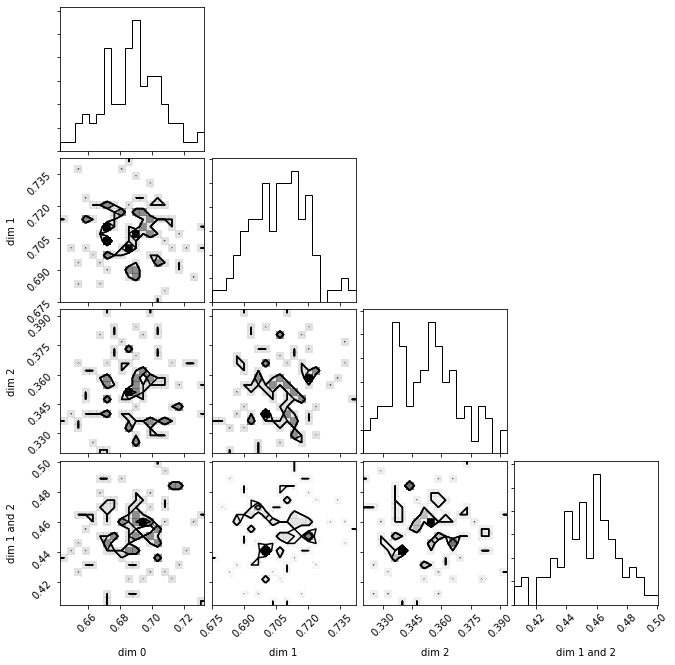

In [4]:
if __name__ == "__main__":
    assert numpyro.__version__.startswith('0.2.4')
    parser = argparse.ArgumentParser(description="Gaussian Process example")
    parser.add_argument("-n", "--num-samples", nargs="?", default=1000, type=int)
    parser.add_argument("--num-warmup", nargs='?', default=500, type=int)
    parser.add_argument("--num-chains", nargs='?', default=1, type=int)
    parser.add_argument("--num-data", nargs='?', default=100, type=int)
    parser.add_argument("--num-dimensions", nargs='?', default=20, type=int)
    parser.add_argument("--active-dimensions", nargs='?', default=3, type=int)
    parser.add_argument("--device", default='cpu', type=str, help='use "cpu" or "gpu".')
    #args = parser.parse_args() 
    args = parser.parse_args(args=[])

    numpyro.set_platform(args.device)
    numpyro.set_host_device_count(args.num_chains)

    main(args)